In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pywt import wavedec
from scipy.signal import find_peaks
from scipy.stats import median_absolute_deviation
from sklearn.linear_model import lars_path

from Scripts.debiasing import debiasing_int, debiasing
from Scripts.fista_update import fista_update as fista
from Scripts.hrf_matrix import HRFMatrix
from Scripts.temporal_ta import filter_boundary as ta_filter
from Scripts.total_activation import total_activation as ta
from Scripts.total_activation import hrf_filters
from Scripts.simulate import fMRIsim
from Scripts.stability_selection import stability_selection

In [2]:
import matplotlib.pylab as pylab
fontsize = 28
params = {'legend.fontsize': fontsize,
         'axes.labelsize': fontsize,
         'axes.titlesize': fontsize,
         'xtick.labelsize': fontsize,
         'ytick.labelsize': fontsize}
pylab.rcParams.update(params)

In [3]:
nscans = 260
params = {'tr': 0.1, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)
# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix_01 = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix_01.generate_hrf()
hrf_SPMG1_01 = hrf_matrix_01.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

test_data_01 = np.zeros(nscans)
test_data_01[int(0/params['tr'])] = 1

bold_pfm_01 = np.dot(hrf_SPMG1_01, test_data_01)
bold_ta_01 = np.real(ta_filter(n, d, test_data_01.T, 'normal', nscans))

time_01 = np.linspace(0, nscans*0.1, nscans)
time_idx_01 = np.where(time_01 >= 24)[0][0]

# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix_2 = HRFMatrix(TR=2, TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix_2.generate_hrf()
hrf_SPMG1_2 = hrf_matrix_2.X_hrf_norm

# Generate hrf filter for TA with spike model
params = {'tr': 2, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

test_data_2 = np.zeros(nscans)
test_data_2[int(0/params['tr'])] = 1

bold_pfm_2 = np.dot(hrf_SPMG1_2, test_data_2)
bold_ta_2 = np.real(ta_filter(n, d, test_data_2.T, 'normal', nscans))

time_2 = np.linspace(0, nscans*2, nscans)
time_idx_2 = np.where(time_2 >= 25)[0][0]


Duration of HRF was not sufficient for specified model. Doubling duration and computing again.
Duration of HRF was not sufficient for specified model. Doubling duration and computing again.
Duration of HRF was not sufficient for specified model. Doubling duration and computing again.
Duration of HRF was not sufficient for specified model. Doubling duration and computing again.


/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


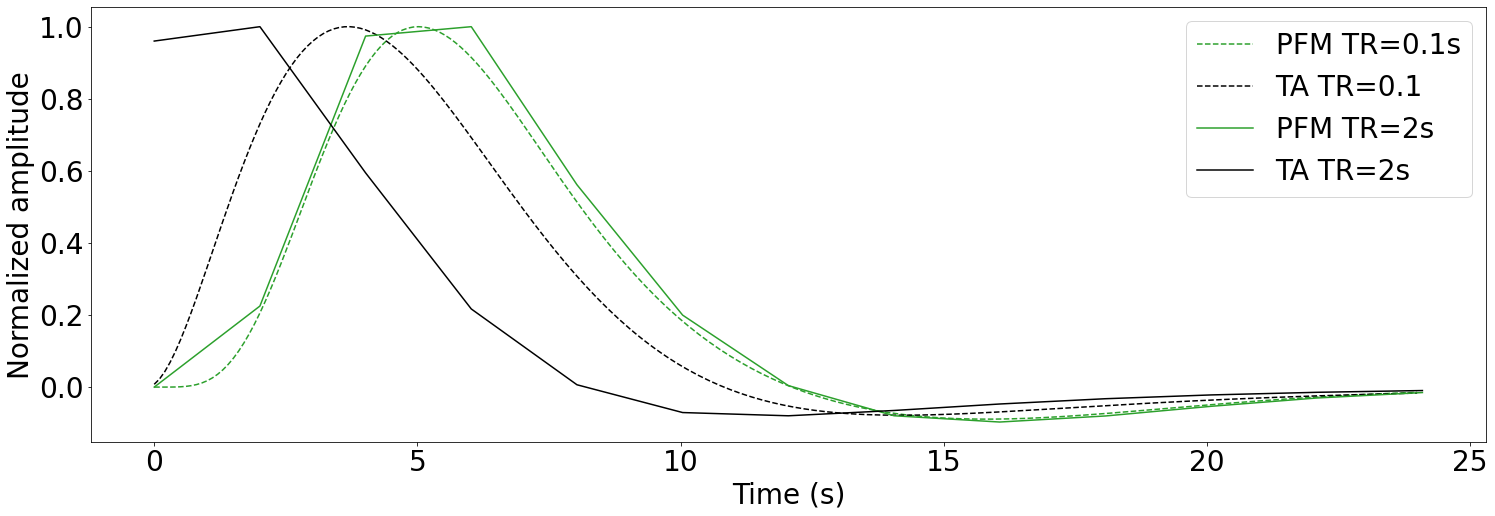

In [4]:
plt.figure(figsize=(25,8))
plt.plot(time_01[:time_idx_01], bold_pfm_01[:time_idx_01]/np.max(bold_pfm_01[:time_idx_01]), label='PFM TR=0.1s', color='tab:green', linestyle="--")
plt.plot(time_01[:time_idx_01], bold_ta_01[:time_idx_01]/np.max(bold_ta_01[:time_idx_01]), label='TA TR=0.1', color='black', linestyle="--")
plt.plot(time_2[:time_idx_2], bold_pfm_2[:time_idx_2]/np.max(bold_pfm_2[:time_idx_2]), label='PFM TR=2s', color='tab:green')
plt.plot(time_2[:time_idx_2], bold_ta_2[:time_idx_2]/np.max(bold_ta_2[:time_idx_2]), label='TA TR=2s', color='black')
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.legend()

In [5]:
params = {'tr': 2, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

test_data = np.zeros(nscans)
test_data[int(0/params['tr'])] = 1

# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

bold_pfm = np.dot(hrf, test_data)
bold_ta = np.real(ta_filter(n, d, test_data.T, 'normal', nscans))

append_2 = 2*nscans - len(bold_ta)
temp = np.append(bold_ta, np.zeros(append_2))
for i in range(nscans-1):
    foo = np.append(np.zeros(i+1), bold_ta)
    append_2 = 2*nscans - len(foo)
    foo = np.append(foo, np.zeros(append_2))
    temp = np.column_stack((temp, foo))

hrf = temp[:nscans, :nscans]

/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Text(0, 0.5, 'Normalized amplitude')

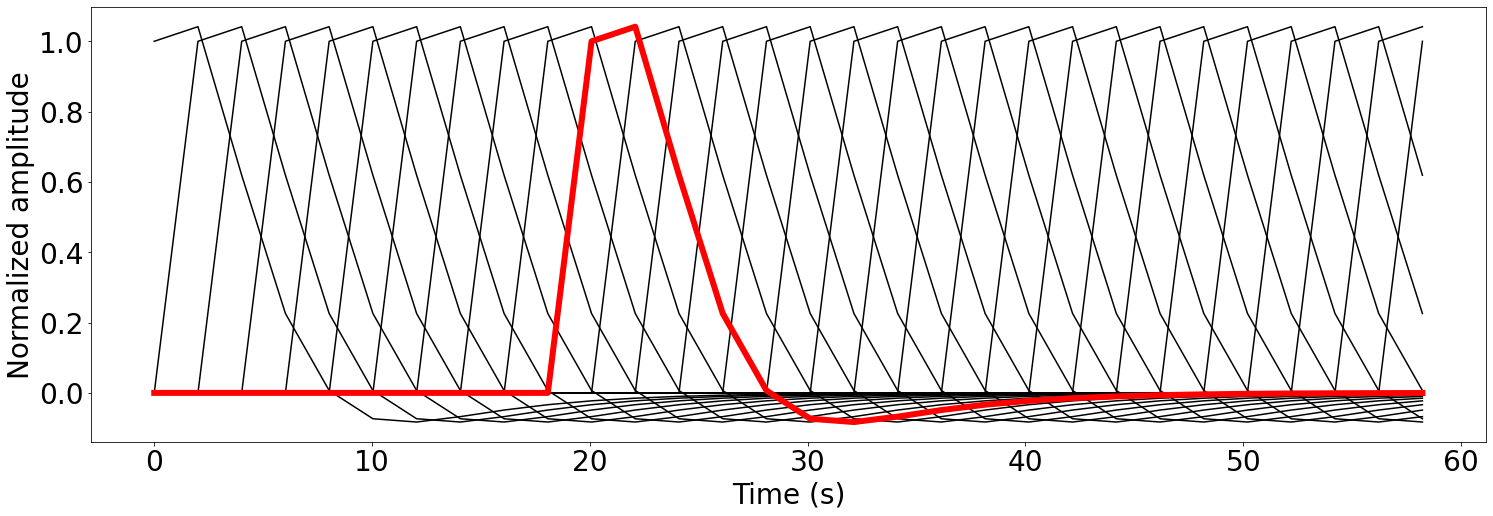

In [6]:
plt.figure(figsize=(25,8))

leng = 30
for i in range(leng):
    plt.plot(time_2[:leng], hrf[:leng,i], color='black')

    
plt.plot(time_2[:leng], hrf[:leng, 10], color='red', linewidth=6)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

In [7]:
# Initialize class
sim = fMRIsim()

# Set parameters
sim.nvoxels = 1
sim.te = [35] # Must be a list
sim.db = 3 # SNR
sim.tr = 2
sim.duration = 400

sim.r2[28:34,:] = 1
sim.r2[50:51,:] = 1
sim.r2[80:81,:] = 1
sim.r2[130:134,:] = 1
sim.r2[138:140,:] = 1

# Simulate timeseries
sim.simulate()

# Load data
data = sim.simulation
ground_truth_bold = sim.bold
ground_truth_beta = sim.r2
ground_truth_inno = sim.innovation
nscans = data.shape[0]
nvoxels = data.shape[1]
print(f'Data has {nscans} scans and {nvoxels} voxels')

Saving simulated data...
Data has 200 scans and 1 voxels


In [8]:
params = {'tr': 2, 'cost_save': True, 'te': [0]} # This is for TA (to follow MATLAB code structure)
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

test_data = np.zeros(nscans)
test_data[int(0/params['tr'])] = 1

# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'], condition2='spmhrf')
n = params['f_recons']['den'][0]
d = [np.array(params['f_recons']['num']), 1]

bold_pfm = np.dot(hrf, test_data)
bold_ta = np.real(ta_filter(n, d, test_data.T, 'normal', nscans))

append_2 = 2*nscans - len(bold_ta)
temp = np.append(bold_ta, np.zeros(append_2))
for i in range(nscans-1):
    foo = np.append(np.zeros(i+1), bold_ta)
    append_2 = 2*nscans - len(foo)
    foo = np.append(foo, np.zeros(append_2))
    temp = np.column_stack((temp, foo))

hrf = temp[:nscans, :nscans]

/Users/enekourunuela/pfm_vs_ta/code/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


In [9]:
# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

# Define the number of lambdas in LARS (relative the length of time series), i.e. no need to compute solutions close to OLS
nlambdas = int(nscans)
min_coeff_amplitude = 1e-3

for vox_idx in range(1): #range(nvoxels):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    pfm_max_lambda = np.max(np.dot(hrf.T, y))
    print(f'PFM max lambda: {pfm_max_lambda}')
    # LARS path
    lambdas_pfm_spike, _, pfm_spike_coef_path = lars_path(hrf, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf.T, hrf),
                                                          Xy = np.dot(hrf.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    
    # Multiply lambdas by nscans due to LARS implementation in scikit learn 
    lambdas_pfm_spike *= nscans
    pfm_spike_coef_path[abs(pfm_spike_coef_path) < min_coeff_amplitude] = 0
    
    # Compute residuals for model selection criteria (BIC and AIC)
    L2res_pfm_spike = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf, pfm_spike_coef_path))**2, axis=0)
    # BIC regularization curve
    bic_pfm_spike = nscans*np.log(L2res_pfm_spike) + np.log(nscans)*np.count_nonzero(pfm_spike_coef_path, axis=0)
    # AIC regularization curve
    aic_pfm_spike = nscans*np.log(L2res_pfm_spike) + 2*np.count_nonzero(pfm_spike_coef_path, axis=0)
    
    # Compute TA for the same regularization path (i.e. same lambdas)
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    #ta_max_lambda = np.max(ta_filter(n, d, y, 'transpose', nscans))
    ta_max_lambda = abs(np.max(y)/np.min(ta_filter(n, d, y, 'transpose', nscans))*params['maxeig'])
    print(f'TA max lambda: {ta_max_lambda}')
    #lambdas_ta_spike = np.geomspace(ta_max_lambda, 0.1*ta_max_lambda, nlambdas)
    lambdas_ta_spike = lambdas_pfm_spike.copy()
    ta_spike_coef_path = np.zeros(pfm_spike_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        ta_coefs, _ = ta(y, params, lambd=lambdas_ta_spike[lambda_idx])
        ta_spike_coef_path[:, lambda_idx] = np.squeeze(ta_coefs)
        
    ta_spike_coef_path[abs(ta_spike_coef_path) < min_coeff_amplitude] = 0
    
    # Compute residuals for model selection criteria (BIC and AIC)
    L2res_ta = np.sum((np.repeat(y, nlambdas, axis=-1) - np.dot(hrf, ta_spike_coef_path))**2, axis=0)
    bic_ta_spike = nscans*np.log(L2res_ta) + np.log(nscans)*np.count_nonzero(ta_spike_coef_path, axis=0)
    aic_ta_spike = nscans*np.log(L2res_ta) + 2*np.count_nonzero(ta_spike_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')

# Find the optimal lambdas for each method (PFM, TA) and each selection criteria (BIC, AIC)    
bic_pfm_spike_idx = np.argmin(bic_pfm_spike)
aic_pfm_spike_idx = np.argmin(aic_pfm_spike)
bic_ta_spike_idx = np.argmin(bic_ta_spike)
aic_ta_spike_idx = np.argmin(aic_ta_spike)

Running LARS for PFM on voxel 1 of 1...
PFM max lambda: 0.1109805181057662
Calculating regularization path for TA on voxel 1 of 1...
TA max lambda: 12.436889269508526
Regularization path of voxel 1 calculated


In [10]:
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']
params['NitTemp'] = 200

_, cD1 = wavedec(y, 'db3', level=1, axis=0)
noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095

ta_coefs, ta_lambdas = ta(y, params, update_lambda=True, lambd=noise_estimate)

mad_lambda = ta_lambdas[-1]
mad_lambda_idx = np.where(lambdas_pfm_spike <= mad_lambda)[0][0]

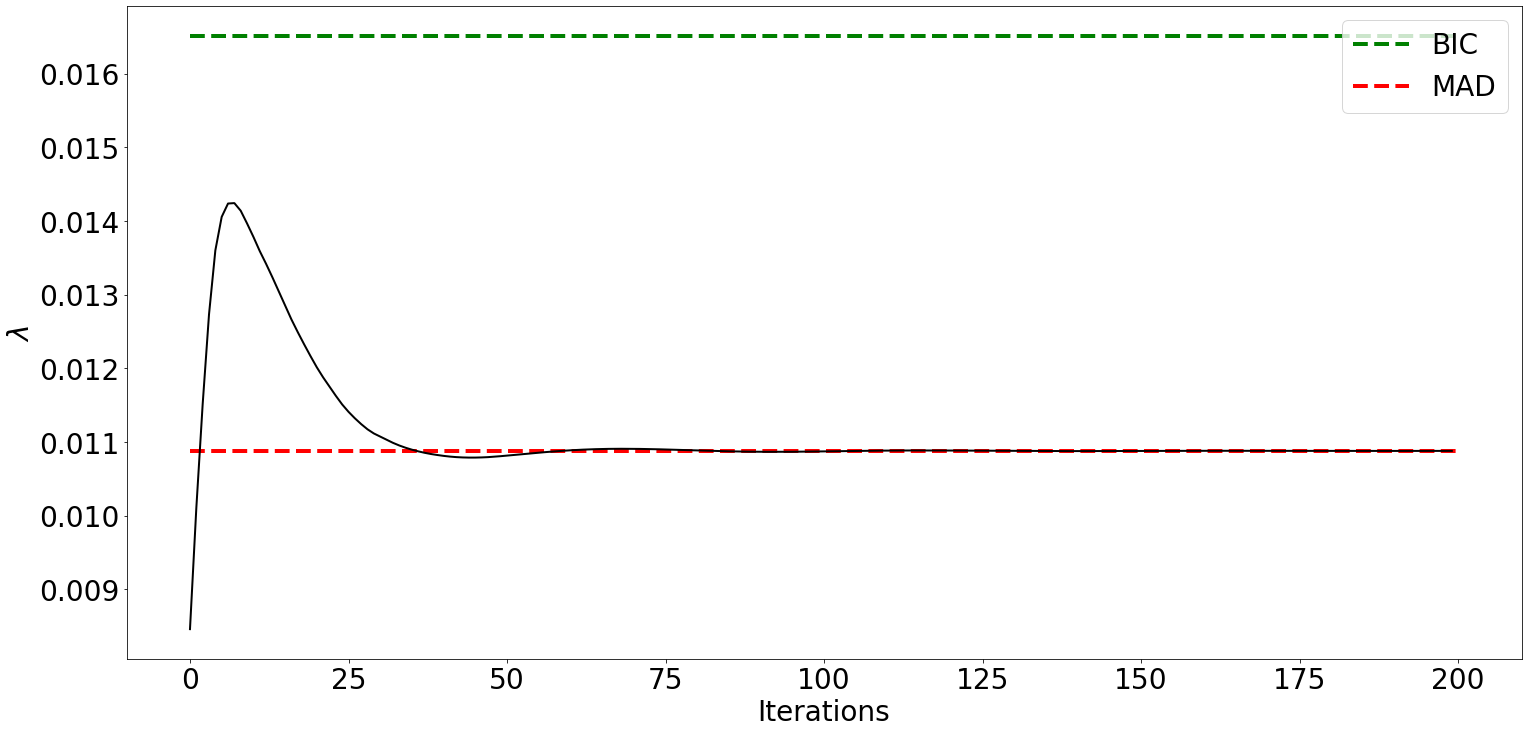

In [11]:
plt.figure(figsize=(25,12))
plt.plot(ta_lambdas, color="black", linewidth=2)
plt.hlines(lambdas_pfm_spike[bic_pfm_spike_idx], xmin=0, xmax=200, color="green", linewidth=4, linestyle="--", label="BIC")
plt.hlines(mad_lambda, xmin=0, xmax=200, color="red", linewidth=4, linestyle="--", label="MAD")
plt.xlabel("Iterations")
plt.ylabel("$\lambda$")
plt.legend()

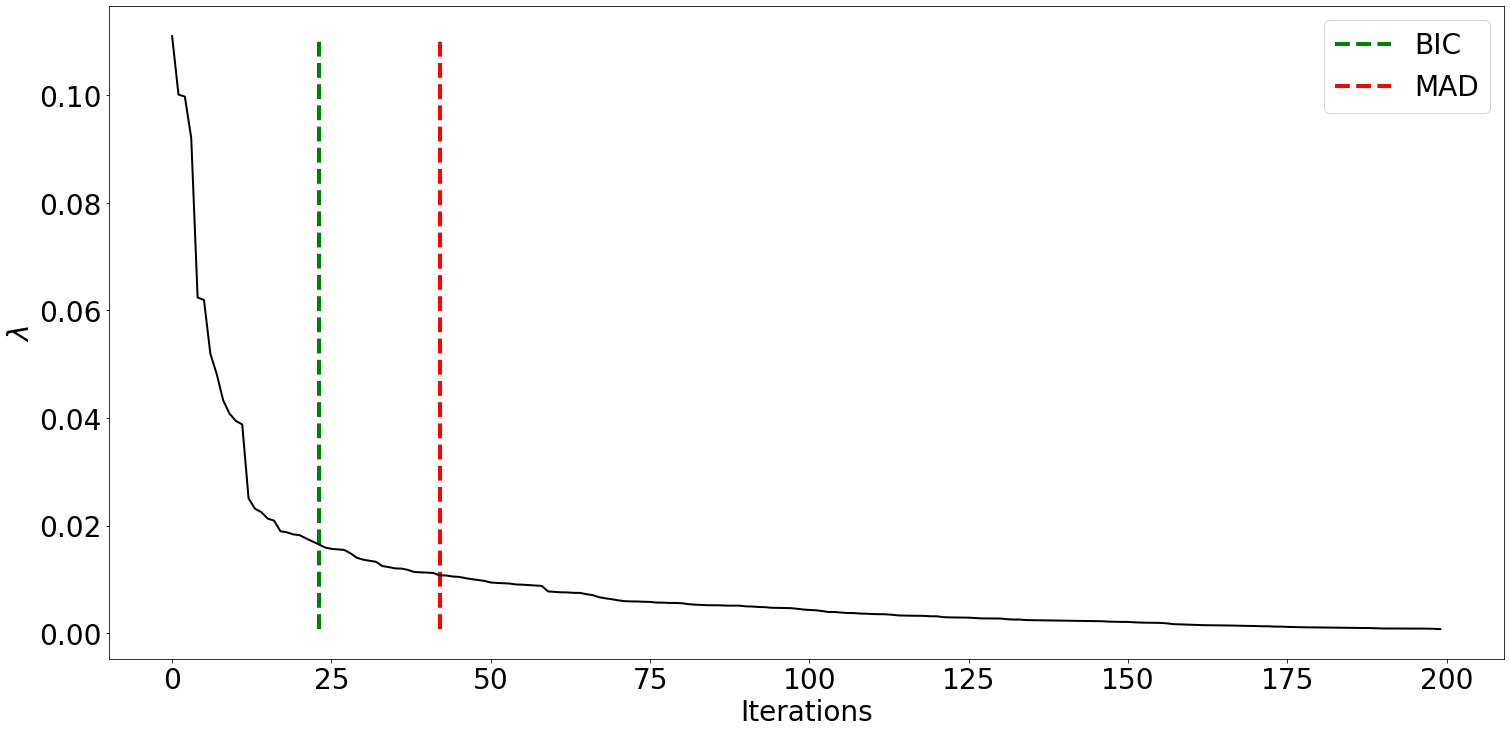

In [12]:
plt.figure(figsize=(25,12))
plt.plot(lambdas_pfm_spike, color="black", linewidth=2)
plt.vlines(bic_pfm_spike_idx, ymin=np.min(lambdas_pfm_spike), ymax=np.max(lambdas_pfm_spike), linewidth=4, color="green", linestyle="--", label="BIC")
plt.vlines(mad_lambda_idx, ymin=np.min(lambdas_pfm_spike), ymax=np.max(lambdas_pfm_spike), linewidth=4, color="red", linestyle="--", label="MAD")
plt.xlabel("Iterations")
plt.ylabel("$\lambda$")
plt.legend()

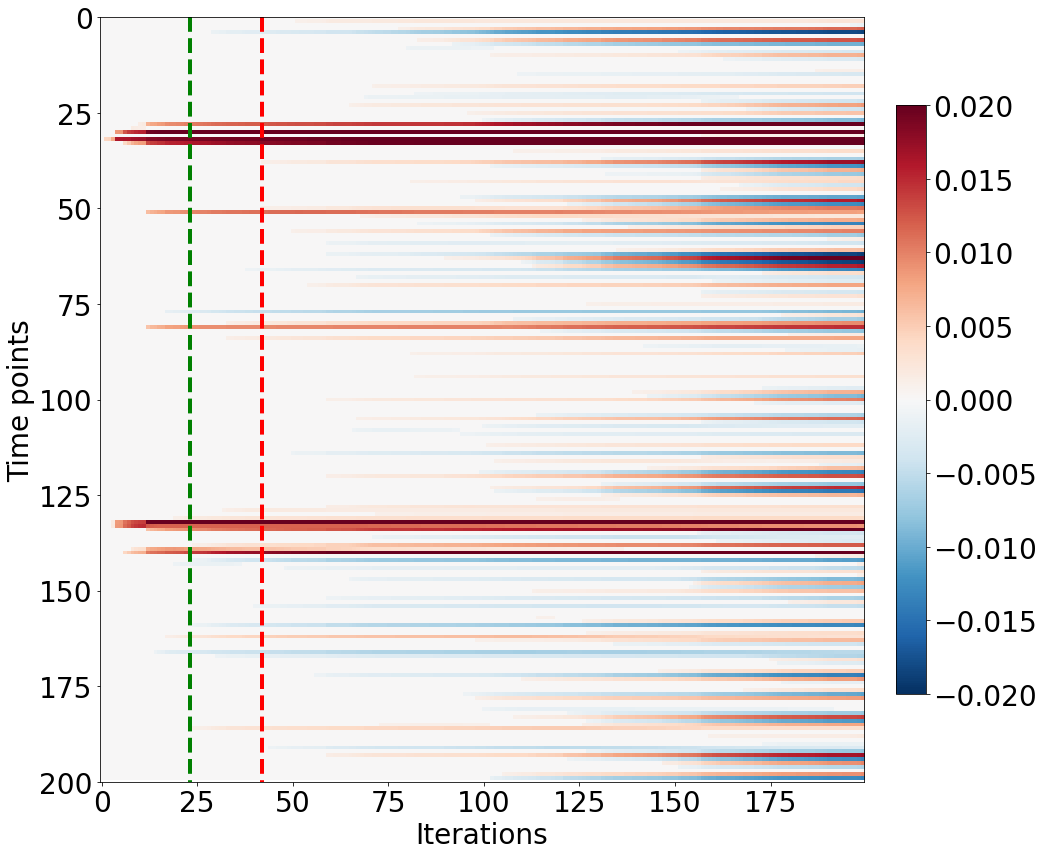

In [13]:
plt.figure(figsize=(45,12))
plt.imshow(pfm_spike_coef_path, cmap='RdBu_r', vmin=-.02, vmax=.02)
plt.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=nscans, color='green', linestyles='dashed', label='BIC', linewidth=4)
plt.vlines(x=mad_lambda_idx, ymin=0, ymax=nscans, color='red', linestyles='dashed', label='BIC', linewidth=4)
plt.ylim([nscans, 0])
ax = plt.gca()
ax.set(xlabel='Iterations', ylabel='Time points')
plt.colorbar(shrink=0.77, pad=0.01)
plt.tight_layout()